### Task 1

$m \in \mathbb{R}^{40}$.

Made measurements:

$ d_1 = m_4 $

$ d_2 = m_5 $

$ d_3 = \frac{1}{2} (m_{12} + m_{13}) $

$ d_4 = m_{31} - m_{30}$

Objective functional:

$ S(m) = \frac{1}{2} (m - m_0)^T W (m - m_0) + \frac{1}{2} (Gm - d_{obs})^T(Gm - d_{obs}) $

Regularization terms:

$ W = I $

$ W = D^T D $

$ W = (D^2)^T D^2 $

$ W = (D^2)^T D^2 + 0.05I $

Observed data: $ d_{obs} = \begin{bmatrix} 5.735 & 2.577 & 4.409 & 0.3497 \end{bmatrix}^T $

Prior etimate: $ m_0 = 5.5 $

$D$ and $D^2$ are finite differenece approximation ro the first and excond derivative operators respectively: $D m_i = m_{i+1} - m_i, D^2 m_i = m_{i-1} - 2m_i + m_{i+1}$

---

### Define $d_{obs} = Gm$

$m \in \mathbb{R}^{40}$

$d_{obs} \in \mathbb{R}^{4}$

$$G = \begin{bmatrix}
0 & 0 & 0 & 1 & 0 & & & & & \cdots \\
0 & 0 & 0 & 0 & 1 & & & & & \cdots \\
& & & \cdots & & & \big(\frac{1}{2} \big)_{12} & \big(\frac{1}{2} \big)_{13} & & \cdots \\
& & & & & & \cdots & & & \big(-1\big)_{30} & \big(1\big)_{31} & \cdots \end{bmatrix}\in \mathbb{R}^{4x40}$$

$m_0 = \begin{bmatrix} 5.5 & 5.5 & \cdots & 5.5 \end{bmatrix}^T  \in \mathbb{R}^{40}$

$D, D^2 \in \mathbb{R}^{40x40}.$

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline

# Define the problem: d_obs = Gm
d_obs = np.array([5.735, 2.577, 4.409, 0.3497])
m_0 =  np.ones(40) * 5.5 

G = np.zeros((4, 40))
G[0, 3] = 1.
G[1, 4] = 1.
G[2, 11], G[2, 12] = .5, .5
G[3, 29], G[3, 30] = -1., 1.

In [2]:
def obj_func(m, m_0, d_obs, G, W):
    term_1 = (m - m_0).T @ W @ (m - m_0) / 2
    term_2 = (G @ m - d_obs).T @ (G @ m - d_obs) / 2
    return term_1 + term_2

def get_D(a=[-1, 1], W=39):
    a = np.asarray(a)
    p = np.zeros(W-1,dtype=a.dtype)
    b = np.concatenate((p,a,p))
    s = b.strides[0]
    strided = np.lib.stride_tricks.as_strided
    return np.vstack((strided(b[W-1:], shape=(W,len(a)+W-1), strides=(-s,s)), np.zeros(W+1)))

def get_W(idx, D=get_D()):
    if idx == 0:
        return np.eye(40, 40)
    
    elif idx == 1:
        return D.T @ D
    
    elif idx == 2:
        return (D @ D).T @ D @ D
    
    elif idx == 3:
        return (D @ D).T @ D @ D + 0.05 * np.eye(40, 40)
    
    else:
        raise ValueError('Index is out of range for regularization terms.')

In [3]:
print(get_D(a=[-1, 1], W=9).shape)
get_D(a=[-1, 1], W=9)

(10, 10)


array([[-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [4]:
get_D(a=[-1, 1], W=9) @ get_D(a=[-1, 1], W=9)

array([[ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [5]:
initial_guess = m_0
err_l = []
d_res = d_obs
for i in range(4):
    result = scipy.optimize.minimize(obj_func, 
                                     initial_guess, 
                                     args=(m_0, d_obs, G, get_W(i)),
    #                                    constraints={'type': 'eq', 'fun': lambda x: x.reshape(4, 4)[2, :].sum() - 1},
    #                                    bounds=b,
                                     options={'maxiter': 1e7},
                                     method='Nelder-Mead')
    
    print(f'Results for {i+1} regularization term:\n    message: {result.message}; function value = {np.round(result.fun, 2)}.')
    
    d = G @ result.x
    err = np.linalg.norm(d_obs - d, 2)
    
    d_res = np.vstack((d_res, d))
    err_l.append(err)
    print(f'    Second norm of error of calculating the d_obs values: {np.round(err, 5)}')
    print('-------------------------------------------------------------------------')

Results for 1 regularization term:
    message: Optimization terminated successfully.; function value = 2.57.
    Second norm of error of calculating the d_obs values: 1.64074
-------------------------------------------------------------------------
Results for 2 regularization term:
    message: Optimization terminated successfully.; function value = 1.73.
    Second norm of error of calculating the d_obs values: 1.52331
-------------------------------------------------------------------------
Results for 3 regularization term:
    message: Optimization terminated successfully.; function value = 1.16.
    Second norm of error of calculating the d_obs values: 1.04472
-------------------------------------------------------------------------
Results for 4 regularization term:
    message: Optimization terminated successfully.; function value = 2.23.
    Second norm of error of calculating the d_obs values: 1.66234
-------------------------------------------------------------------------


### Analytical solution

**Objective functional:**

$$ S(m) = \frac{1}{2} (m - m_0)^T W (m - m_0) + \frac{1}{2} (Gm - d_{obs})^T(Gm - d_{obs}) $$

**Gradient of functional (I did some excess steps, I know, but I easily do mistakes, so it's just save approach):**

$$ S(m) = \frac{1}{2} \bigg( (m - m_0)^T W (m - m_0) + (Gm - d_{obs})^T (Gm - d_{obs}) \bigg) \iff$$

$$ \iff S(m) = \frac{1}{2} \bigg[ \big( m^T W m - m^T W m_0 - m_0^T W m - m_0^T W m_0 \big) + \big( m^T G^T G m - m^T G^T d_{obs} - d_{obs}^T G m + d_{obs}^2 \big) \bigg] $$

Lets introduce $f(m)$ and $g(m)$:

$$ f(m) = m^T W m - m^T W m_0 - m_0^T W m - m_0^T W m_0, $$

$$ g(m) = m^T G^T G m - m^T G^T d_{obs} - d_{obs}^T G m + d_{obs}^2 $$

Take differential of $f$ and $g$:

$$ d(f) = (dm)^T W m + m^T W dm - (dm)^T W m_0 - m_0^T W dm \iff d(f) = 2 \bigg( m^T W dm - m_0^T W dm \bigg) $$

$$ d(g) = (dm)^T G^T G m + m^T G^T G dm - (dm)^T G^T d_{obs} - d_{obs}^T G dm \iff d(g) = 2 \bigg( m^T G^T G dm - d_{obs}^T G dm \bigg) $$

Back to $S(m)$:

$$ d(S) = m^T W^T dm - m_0^T W^T dm + m^T G^T G dm - d_{obs}^T G dm \implies $$

$$ \implies \nabla S = m^T W^T - m_0^T W^T + m^T G^T G - d_{obs}^T G $$

Condition of minimum $\nabla S = 0$:

$$ 0 = m^T W^T - m_0^T W^T + m^T G^T G - d_{obs}^T G \iff 0 = W m - W m_0 + G^T G m - G^T d_{obs} \iff $$

$$ \iff \big( W + G^T G \big) m = W m_0 + G^T d_{obs} \iff $$

$$ \iff m = \big(W + G^T G \big)^{-1} \big( W m_0 + G^T d_{obs} \big) $$

In [6]:
def analytical_m(G, m_0, d_obs, w_index, mode='my'):
    W = get_W(w_index)
    if mode == 'my':
        m = np.linalg.inv(W + G.T @ G) @ (W @ m_0 + G.T @ d_obs)
    elif mode == 'TA':
        m = m_0 + numpy.linalg.inv(W + G.T @ G) @ G.T @ (d_obs - G @ m_0)
    return m

In [7]:
tol = 1e-12

In [8]:
err_expl_l = []
d_expl_res = d_obs
m_l = []

for i in range(4):
    initail_m = m_0
    err = 1e8
    while err > tol:
        m = analytical_m(G, initail_m, d_obs, i)
        d = G @ m
        initail_m = m
        
        err = np.linalg.norm(d_obs - d, 2)
        
    m_l.append(m)
    d_expl_res = np.vstack((d_expl_res, d))
    err_expl_l.append(err)
    print(f'Results for {i+1} regularization term.')
    print(f'    Second norm of error of calculating the d_obs values: {np.round(err, 5)}')
    print('-------------------------------------------------------------------------')

Results for 1 regularization term.
    Second norm of error of calculating the d_obs values: 0.0
-------------------------------------------------------------------------
Results for 2 regularization term.
    Second norm of error of calculating the d_obs values: 0.0
-------------------------------------------------------------------------
Results for 3 regularization term.
    Second norm of error of calculating the d_obs values: 0.0
-------------------------------------------------------------------------
Results for 4 regularization term.
    Second norm of error of calculating the d_obs values: 0.0
-------------------------------------------------------------------------


In [9]:
print('Results with scipy.optimize')
pd.DataFrame(np.vstack((d_res, err_l)).T, columns=['Ground Truth', '$W_1$', '$W_2$', '$W_3$', '$W_4$', '2nd norm'])

Results with scipy.optimize


,Ground Truth,$W_1$,$W_2$,$W_3$,$W_4$,2nd norm
0,5.7350,5.617434,4.712093,5.061585,4.782214,1.640745
1,2.5770,4.038417,3.688703,3.357673,3.894152,1.523309
2,4.4090,5.136242,4.321669,4.275055,4.671149,1.044721
3,0.3497,0.233074,0.174712,0.246931,0.121738,1.662342


In [10]:
print('Results of explicit expression')
pd.DataFrame(np.vstack((d_expl_res, err_expl_l)).T, columns=['Ground Truth', '$W_1$', '$W_2$', '$W_3$', '$W_4$', '2nd norm'])

Results of explicit expression


,Ground Truth,$W_1$,$W_2$,$W_3$,$W_4$,2nd norm
0,5.7350,5.7350,5.7350,5.7350,5.7350,7.736040e-13
1,2.5770,2.5770,2.5770,2.5770,2.5770,7.733532e-13
2,4.4090,4.4090,4.4090,4.4090,4.4090,7.892628e-13
3,0.3497,0.3497,0.3497,0.3497,0.3497,7.675420e-13


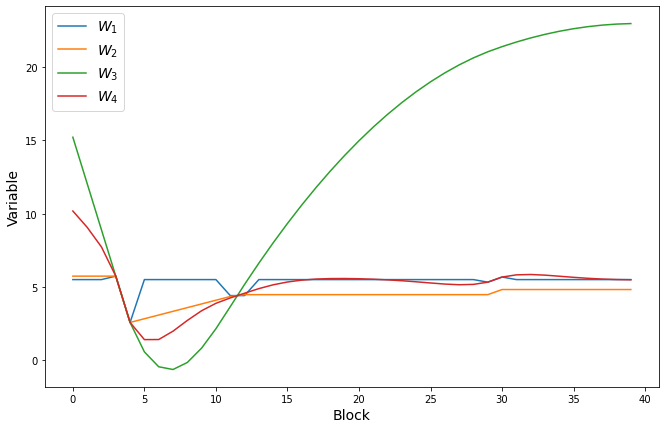

In [11]:
plt.rcParams['figure.figsize'] = (11, 7)
for m, n in zip(m_l, ['$W_1$', '$W_2$', '$W_3$', '$W_4$']):
    plt.plot(m, label=n)

plt.xlabel('Block', fontsize=14)
plt.ylabel('Variable', fontsize=14)
plt.legend(fontsize=14);

## Task 2

Let a point be picked at random (uniform density) in the unit square.  Compute the probability that 
it  is  in  the  triangle  bounded  by  𝑥 =0,  𝑦=0,  and  𝑥+𝑦=1.  Recompute  the  probability  if 
𝑓𝑋(𝑥)=2𝑥 and 𝑓𝑌(𝑦)=2(1−𝑦) and 𝑥 and 𝑦 are independent random variables. 

### Analytical solution

**First part** is trivial: since point coordinates are from uniform distribution, and specified region is a half of the whole domain, the probability is 0.5 as well.

**Second part**:

Variables are independet $\implies f_{XY} = f_X \space f_Y$

$\space D: \{x > 0, y > 0, x < 1 - y\}, \space f_X = 2x, \space f_Y = 2(1 - y) $

Introduce: $u = 2x \space \land \space v = 2(1 - y) \iff x = \frac{u}{2} \land y = \frac{2 - v}{2}$

Probability:

$$ P\{(U, V) \in D'\} =  \iint_{D'} f_{UV}(u, v) \, du dv = \iint_{D'} f_U(u) f_V(v) \, du dv = \iint_{D} f_X(x) f_Y(y) \, \big| \det(J) \big| \, dx dy, $$

where $J$ is a Jacobian:

$$ J = \begin{bmatrix} \frac{1}{2} & 0 \\ 0 & -\frac{1}{2} \end{bmatrix} = -\frac{1}{4}. $$

$$ P\{(X, Y) \in D\} = \iint_{D} 2x \cdot 2(1 - y) \cdot \frac{1}{4} \, dx dy = \int_0^1 dx \int_0^{1 - x} x(1 - y) \, dy = \int_0^1 \big( x(1 - x) - x \frac{(1 - x)^2}{2} \big) \, dx = \frac{1}{8} = 0.125$$


### Numerical solution

In [12]:
def pick_point(mode=0):
    if mode == 0:
        return (np.random.uniform(0, 1), np.random.uniform(0, 1))
    elif mode == 1:
        a, b = pick_point()
        return 2 * a, 2 * (1 - b)

def prob_in_tri(n, mode=0):
    m = 0
    for i in range(n):
        x, y = pick_point(mode)
        if (y < (1 - x)) & (x > 0) & (y > 0):
            m += 1
    return m / n        

In [13]:
print(f'First probability is {prob_in_tri(100000, 0)}')
print(f'Second probability is {prob_in_tri(100000, 1)}')

First probability is 0.49724
Second probability is 0.1249


## Task 3

For  the  following  two  examples,  compute  the  expectations  of  𝑋,  𝑌  and  𝐸[𝑋𝑌].  Compute  the 
covariance of 𝑋 and 𝑌. Are the two variables correlated? Are the two variables independent? For 
both cases, what is the conditional probability that 𝑥 =1 given that 𝑦=1?

![image](https://drive.google.com/uc?export=view&id=15-DtR5nul4-lIU4GuTiP2Do7gkiW0hyt)


#### First Part

$ \mathop{\mathbb{E}}(X) = 0.5, \, \mathop{\mathbb{E}}(Y) = 1.3, \, \mathop{\mathbb{E}}(XY) = 0.8 $

$ cov(X, Y) = \mathop{\mathbb{E}}(XY) - \mathop{\mathbb{E}}(X) \mathop{\mathbb{E}}(Y); \space cov(X, Y) = 0.15 $

$cov \neq 0 \implies$ variables are dependent.

$ P(x=1|y=1) = 0.4 $

#### Second Part

$ \mathop{\mathbb{E}}(X) = 0.66, \, \mathop{\mathbb{E}}(Y) = 0, \, \mathop{\mathbb{E}}(XY) = 0 $

$ cov(X, Y) = \mathop{\mathbb{E}}(XY) - \mathop{\mathbb{E}}(X) \mathop{\mathbb{E}}(Y); \space cov(X, Y) = 0 $

$cov = 0 \implies$ variables uncorrelated, but we can't say whether they are dependent or not. To find dependecy, we can check if the joint probability is equal to а product of marginal probabilities.

$ P(x=1|y=1) = 1 $

$ P(x=1) = 0.66, \, P(y=1) = 0.33 $

$ 1 \neq 0.66 \cdot 0.33 \implies $ variables are dependent 